In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
import random

/home/onyxia/work/statapp-hsbc/utils/metrics.py:45: SyntaxWarning: invalid escape sequence '\ '
  """Tracer la variance des taux de croissances de sous échantillons de la série réelles et générées"
/home/onyxia/work/statapp-hsbc/utils/metrics.py:75: SyntaxWarning: invalid escape sequence '\ '
  """Tracer la moyenne des taux de croissances de sous échantillons de la série réelles et générées"


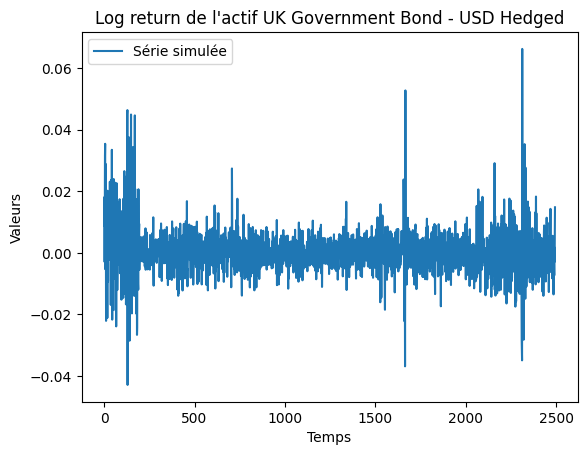

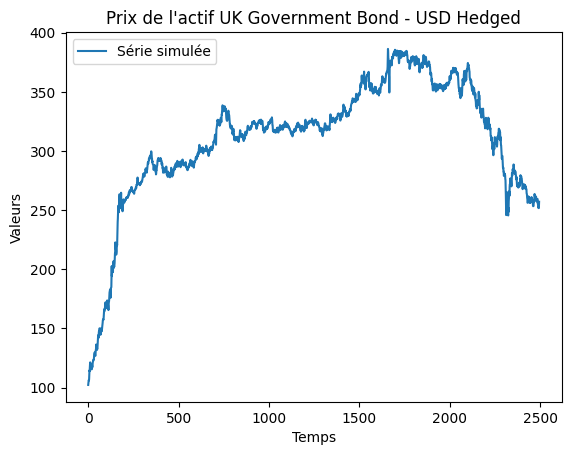

In [2]:
# Charger le data set
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

In [3]:
from utils.base_gan import Generator, Discriminator

In [6]:
# Entrainement du modèle de base, celui ci se trouve dans la variable train_ff
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 100 # Dimension de sortie
conditional = 20 # Dimension de la partie "commune"
epochs = 200
generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_ff = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda, _lambda=3, limite=20)
train_ff.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  56272


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                             

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 6


In [9]:
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator

In [11]:
# Entrainement du 2ème modèle
generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_lstm = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, 
        conditional=conditional,use_cuda=use_cuda, _lambda=3, limite=20, is_recc=True)
train_lstm.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  305232


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                               

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 10


In [12]:
from utils.network import Generator, Discriminator

In [13]:
# 3ème modèle

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional, dropout_prob=0.4, hidden=128)#, dropout_prob=0.2, hidden = 64)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-6
lr_b = 1e-6
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = './model'
print("Utilisation du Gpu :",use_cuda)

print("Nombre de paramètres à entrainer : ", sum(p.numel() for p in generator.parameters() if p.requires_grad))

train_cnn = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, 
                    D_scheduler, G_scheduler, conditional=conditional,
                    use_cuda=use_cuda, _lambda=2, limite=20, window=1, vega = np.inf,theta = 20)
train_cnn.train_model(epochs=epochs)

Utilisation du Gpu : True
Nombre de paramètres à entrainer :  273242


  0%|          | 0/200 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1346: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
                                                                                                 

Arret préliminaire, aucune amélioration du modèle depuis 20 epochs
Last epoch : 123


In [14]:
from utils.network import show_generations

ImportError: cannot import name 'show_generations' from 'utils.network' (/home/onyxia/work/statapp-hsbc/utils/network.py)

In [18]:
def show_generations(num, train, amplifier=1, reducer=4, show_real=True, alpha=0.3, start =random.randint(200,2000)):
    amplifier = 1
    noise = torch.randn((num, 1, train.latent_dim)) * amplifier
    real_samples = torch.from_numpy(y[start:start+train.conditional])
    noise[:, :, :train.conditional] = real_samples
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    noise = noise.to(device)
    v = train.G(noise) / reducer
    v[:, :, :train.conditional] = real_samples
    v = np.array(v.float().cpu().detach()[:, 0,  :])
    print(start)
    for ar in v:
        plt.plot(ar, alpha=alpha)
    if show_real:
        plt.plot(y[start:start+train.ts_dim-train.conditional], label='real serie')
    plt.legend()
    plt.show()
    return v

1921


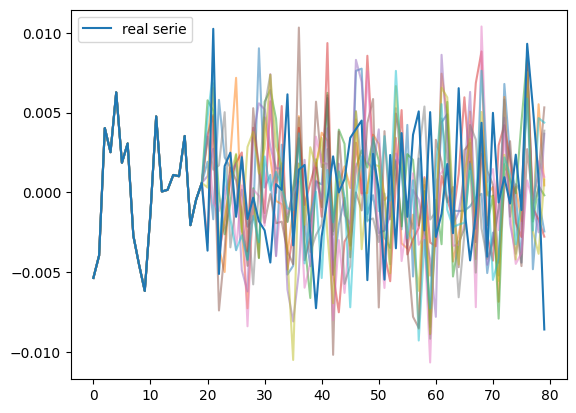

1921


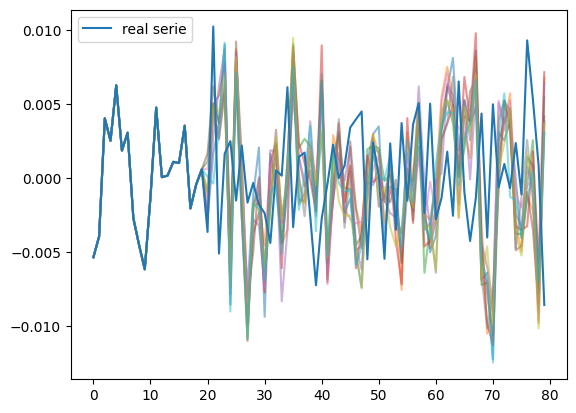

1921


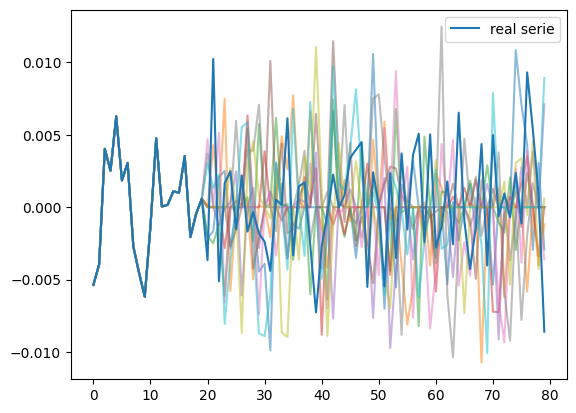

In [21]:
start = random.randint(200,2000)
fake_return_ff = show_generations(train = train_ff,num=10, reducer=15, start=start, alpha=0.5) # Reducer pour gérer l'amplitude des donées, généralement
# 15 pour le base, 10 pour LSTM et entre 2 et 5 pour cnn
fake_return_lstm = show_generations(train = train_lstm,num=10, reducer=5, start = start, alpha=0.5)
fake_return_cnn = show_generations(train = train_cnn,num=10, reducer=4, start = start, alpha=0.5)

In [31]:
def get_multiple(r, divizer):
    quotient, reste = divmod(r, divizer)
    if reste == 0:
        return r
    else:
        return (quotient + 1) * divizer

In [34]:
get_multiple(500, 80)

560

In [48]:
train_ff.ts_dim-train_ff.conditional

80

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 170.62it/s]


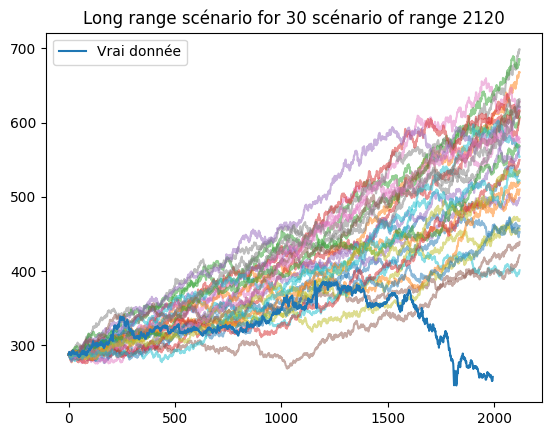

100%|██████████| 34/34 [00:00<00:00, 220.45it/s]


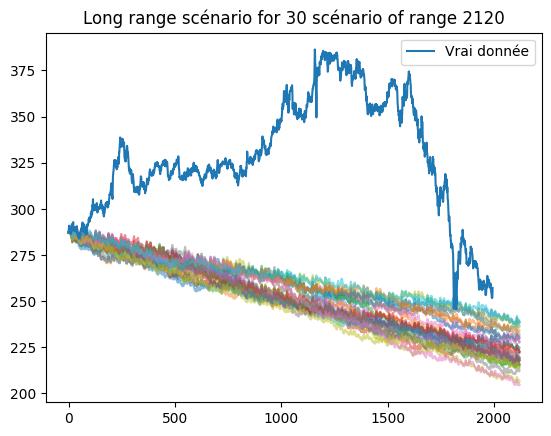

100%|██████████| 34/34 [00:00<00:00, 70.31it/s]


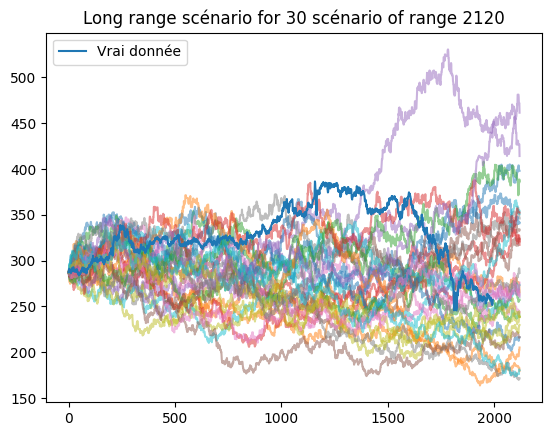

In [50]:
# Pour des scénarios de longue durée
start = 500
v, fake_lines_ff = generate_long_range(y[start:],true_y[start:],train_ff,length=2000, n=30,reducer=15, show_real=True ,amplifier=1, superpose=False)
_, fake_lines_lstm = generate_long_range(y[start:],true_y[start:],train_lstm,length=2000, n=30,reducer=10, show_real=True ,amplifier=1, superpose=False)
_, fake_lines_cnn = generate_long_range(y[start:],true_y[start:],train_cnn,length=2000, n=30,reducer=2, show_real=True ,amplifier=1, superpose=False)

(2121,)


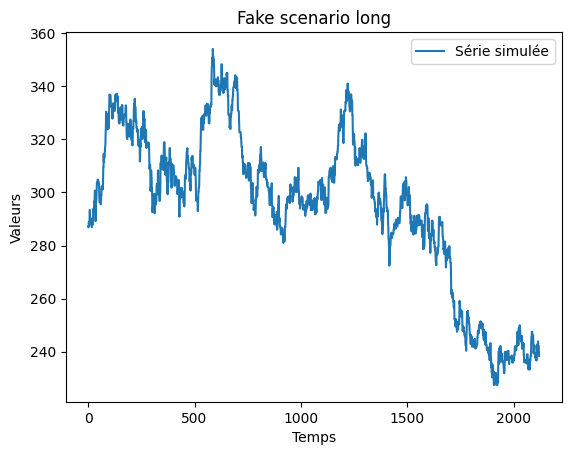

In [56]:
# On a donc les array d'un scénario long dans fake_lines_[model]
print(fake_lines_cnn[2].shape)
simple_plot(fake_lines_cnn[2], title="Fake scenario long")

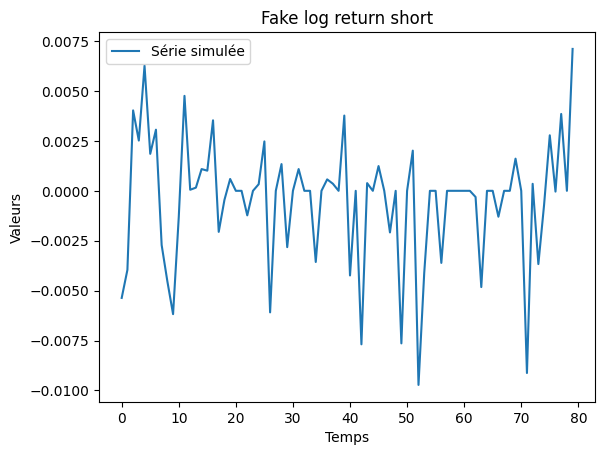

In [53]:
# Scenario de log return cours
simple_plot(fake_return_cnn[4], title="Fake log return short")

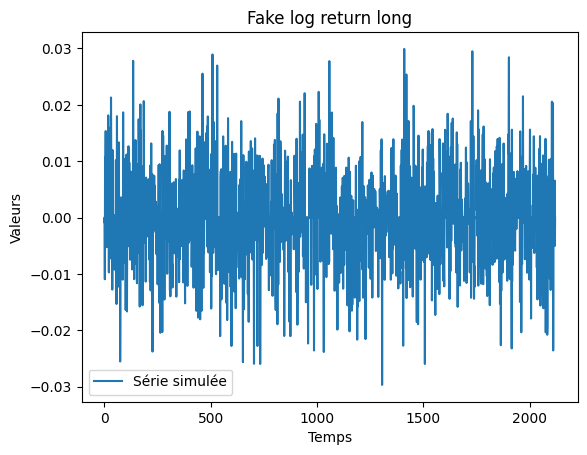

In [55]:
# Scenario log return long
# Choisir indice i
i=10
long_log_return_cnn = np.log(fake_lines_cnn[i,1:] / fake_lines_cnn[i,:-1])
simple_plot(long_log_return_cnn, title="Fake log return long")